In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings("ignore")

from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import randint, uniform

In [2]:
try:
    import xgboost as xgb
    from xgboost import XGBClassifier
except Exception:
    XGBClassifier = None

try:
    from skopt import BayesSearchCV
    use_bayes = True
except Exception:
    use_bayes = False


In [3]:
print("📥 Loading Covertype dataset...")
cov = fetch_covtype()
X = pd.DataFrame(cov.data, columns=cov.feature_names).astype(np.float32)
y = pd.Series(cov.target.astype(np.int32), name='CoverType')

print(f"Dataset shape: X={X.shape}, y={y.shape}")
print("\nTarget distribution (counts):")
print(y.value_counts().sort_index())

📥 Loading Covertype dataset...
Dataset shape: X=(581012, 54), y=(581012,)

Target distribution (counts):
CoverType
1    211840
2    283301
3     35754
4      2747
5      9493
6     17367
7     20510
Name: count, dtype: int64


In [4]:
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)
print(f"\nSplit: X_train={X_train.shape}, X_test={X_test.shape}")


Split: X_train=(464809, 54), X_test=(116203, 54)


In [5]:
import numpy as np

unique_classes = np.unique(y_train)
class_mapping = {old: new for new, old in enumerate(unique_classes)}
y_train = y_train.map(class_mapping)
y_test = y_test.map(class_mapping)

In [6]:
class_dist = y_train.value_counts(normalize=True).sort_index()
print("\n📊 Train class distribution (proportions):")
print(class_dist)


📊 Train class distribution (proportions):
CoverType
0    0.364606
1    0.487598
2    0.061537
3    0.004729
4    0.016338
5    0.029892
6    0.035301
Name: proportion, dtype: float64


In [7]:
from sklearn.utils.class_weight import compute_class_weight
unique_classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=unique_classes, y=y_train)
class_weight_dict = {int(c): w for c, w in zip(unique_classes, class_weights)}
print("\nClass weights (for sklearn models):")
print(class_weight_dict)


Class weights (for sklearn models):
{0: np.float64(0.39181272253992233), 1: np.float64(0.29298131712974634), 2: np.float64(2.3214797648598298), 3: np.float64(30.209866112049916), 4: np.float64(8.743914368486399), 5: np.float64(4.779133850171708), 6: np.float64(4.046884794873581)}


In [8]:
sample_weights_train = y_train.map(lambda cls: class_weight_dict[int(cls)]).values

In [9]:
print("\n Training baseline RandomForest (n_estimators=100)...")
t0 = time.time()
rf_baseline = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1, class_weight='balanced')
rf_baseline.fit(X_train, y_train)
t1 = time.time()
print(f"Trained in {t1 - t0:.1f}s")

y_pred_rf = rf_baseline.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf, average='macro')
print(f"RandomForest baseline -> Accuracy: {acc_rf:.4f}, F1_macro: {f1_rf:.4f}")



 Training baseline RandomForest (n_estimators=100)...
Trained in 77.1s
RandomForest baseline -> Accuracy: 0.9546, F1_macro: 0.9247


In [10]:
if XGBClassifier is not None:
    print("\n Training baseline XGBoost (n_estimators=100)...")
    t0 = time.time()
    xgb_baseline = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='mlogloss',
                                 random_state=RANDOM_STATE, n_jobs=-1, verbosity=0)
    # pass sample_weight to handle imbalance
    xgb_baseline.fit(X_train, y_train, sample_weight=sample_weights_train)
    t1 = time.time()
    print(f"Trained in {t1 - t0:.1f}s")

    y_pred_xgb = xgb_baseline.predict(X_test)
    acc_xgb = accuracy_score(y_test, y_pred_xgb)
    f1_xgb = f1_score(y_test, y_pred_xgb, average='macro')
    print(f"XGBoost baseline -> Accuracy: {acc_xgb:.4f}, F1_macro: {f1_xgb:.4f}")
else:
    acc_xgb = f1_xgb = None
    print("\n XGBoost not installed — skipping XGBoost baseline.")


 Training baseline XGBoost (n_estimators=100)...
Trained in 37.5s
XGBoost baseline -> Accuracy: 0.8318, F1_macro: 0.8010


In [11]:
def plot_confusion_matrices(y_true, y_pred, labels=None, figsize=(14,6)):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=figsize)
    plt.subplot(1,2,1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix (counts)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    plt.subplot(1,2,2)
    sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix (percent per actual class)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()
    return cm, cm_percent


🔎 Confusion matrix for RandomForest baseline:


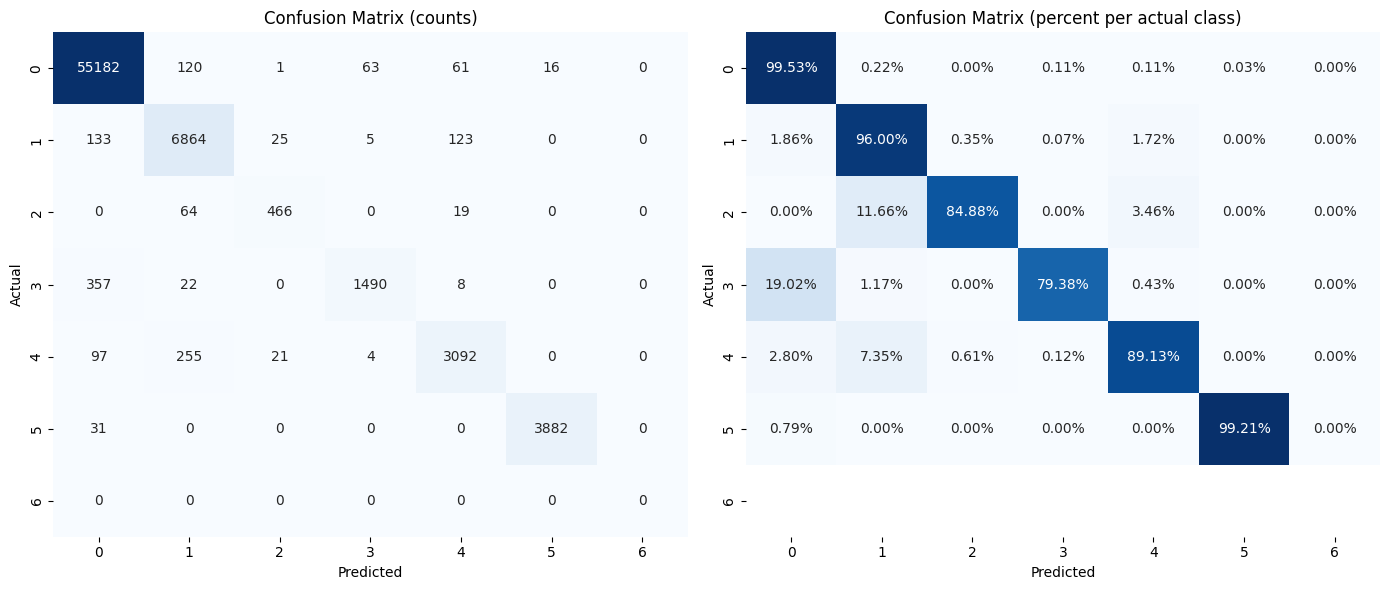


Classification report (RandomForest baseline):
              precision    recall  f1-score   support

           0     0.9653    0.9429    0.9540     42368
           1     0.9495    0.9739    0.9615     56661
           2     0.9368    0.9599    0.9482      7151
           3     0.9084    0.8488    0.8776       549
           4     0.9503    0.7846    0.8595      1899
           5     0.9356    0.8903    0.9124      3473
           6     0.9732    0.9464    0.9596      4102

    accuracy                         0.9546    116203
   macro avg     0.9456    0.9067    0.9247    116203
weighted avg     0.9547    0.9546    0.9544    116203



In [12]:
print("\n🔎 Confusion matrix for RandomForest baseline:")
cm_rf, cm_rf_percent = plot_confusion_matrices(y_test, y_pred_rf, labels=np.unique(y))
print("\nClassification report (RandomForest baseline):")
print(classification_report(y_test, y_pred_rf, digits=4))

In [13]:
threshold = 0.70
report_dict = classification_report(y_test, y_pred_rf, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
weak_classes = [int(idx) for idx in report_df[(report_df['f1-score'] < threshold) & (report_df.index.map(lambda x: str(x).isdigit()))].index]
print(f"\n Weak classes (F1 < {threshold}): {weak_classes}")


 Weak classes (F1 < 0.7): []


In [14]:

if weak_classes:
    # show counts in test set
    print("\nCounts of weak classes in test set:")
    print(y_test.value_counts().loc[weak_classes])
    # PCA visualization of weak classes (samples actual vs predicted)
    # prepare sample subset
    mask = y_test.isin(weak_classes)
    if mask.sum() > 10:
        subset_X = X_test[mask]
        subset_y = y_test[mask]
        subset_y_pred = pd.Series(y_pred_rf, index=y_test.index)[mask]
        scaler = StandardScaler()
        sub_scaled = scaler.fit_transform(subset_X)
        pca = PCA(n_components=2, random_state=RANDOM_STATE)
        sub_pca = pca.fit_transform(sub_scaled)
        plt.figure(figsize=(8,6))
        sns.scatterplot(x=sub_pca[:,0], y=sub_pca[:,1], hue=subset_y.astype(str), style=subset_y_pred.astype(str), palette='tab10')
        plt.title('PCA of Weak-Class Samples (actual vs predicted)')
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.legend(title='actual / predicted', bbox_to_anchor=(1.05, 1))
        plt.show()
    else:
        print("Not enough samples in weak classes for PCA visualization.")


 RandomForest feature importance (top 20):


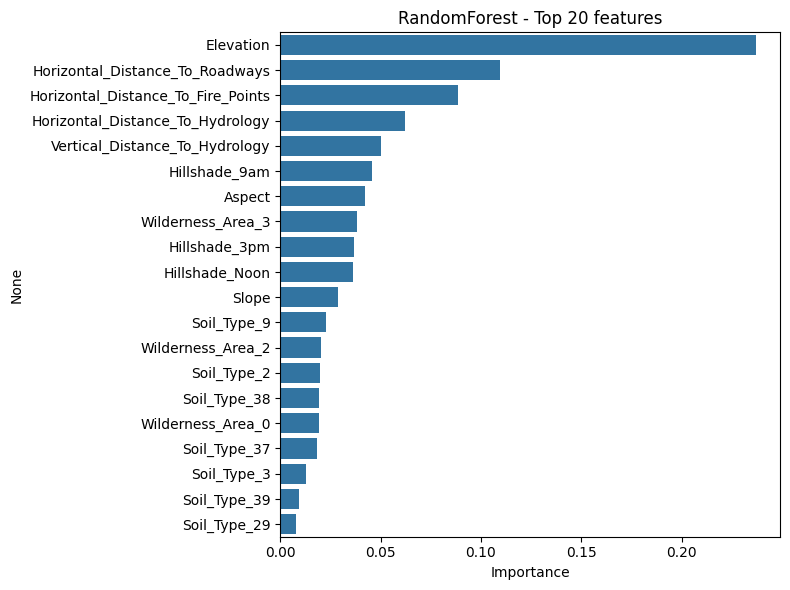


 XGBoost feature importance (top 20):


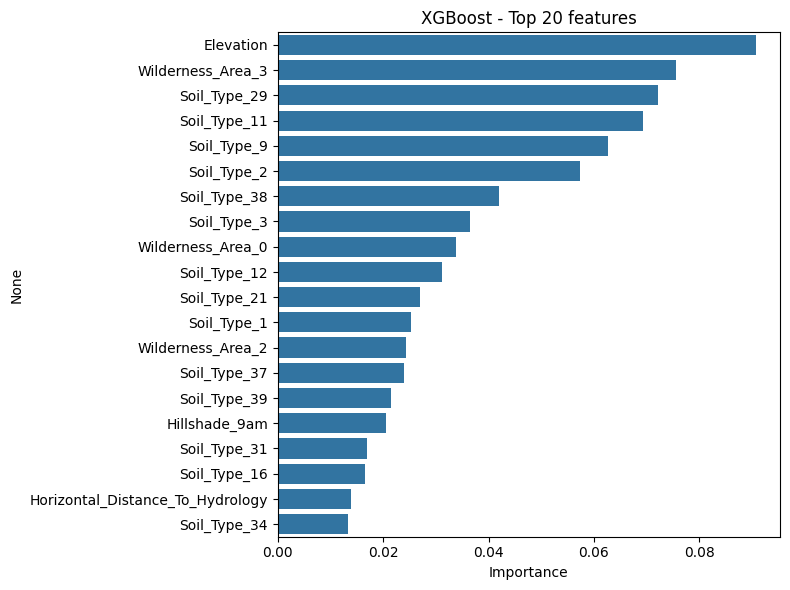

In [15]:
def plot_feature_importances(model, X_df, top_n=20, title="Feature importance"):
    if hasattr(model, "feature_importances_"):
        imp = model.feature_importances_
        feat_imp = pd.Series(imp, index=X_df.columns).sort_values(ascending=False).head(top_n)
        plt.figure(figsize=(8,6))
        sns.barplot(x=feat_imp.values, y=feat_imp.index)
        plt.title(title)
        plt.xlabel("Importance")
        plt.tight_layout()
        plt.show()
    else:
        print("Model has no feature_importances_ attribute.")

print("\n RandomForest feature importance (top 20):")
plot_feature_importances(rf_baseline, X, top_n=20, title="RandomForest - Top 20 features")

if XGBClassifier is not None:
    print("\n XGBoost feature importance (top 20):")
    try:
        plot_feature_importances(xgb_baseline, X, top_n=20, title="XGBoost - Top 20 features")
    except Exception:
        # xgboost's feature_importances_ may work similarly
        print("Could not plot XGBoost feature importances using same function.")



⚙️ Hyperparameter tuning (RandomForest) -- RandomizedSearchCV (Fast Mode)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
RandomizedSearchCV finished in 626.8s
Best RF params: {'max_depth': 18, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 132}
Tuned RandomForest -> Accuracy: 0.8630, F1_macro: 0.8168

Confusion matrix for tuned RandomForest:


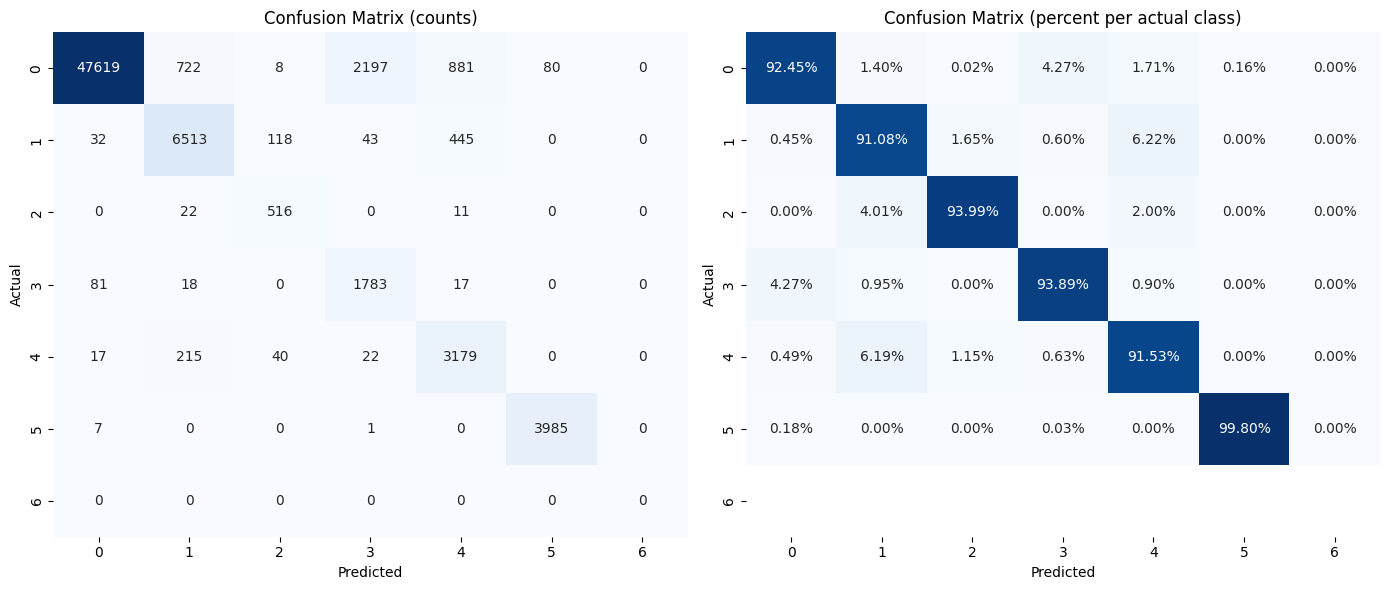


Classification report (Tuned RandomForest):
              precision    recall  f1-score   support

           0     0.8746    0.8661    0.8703     42368
           1     0.9124    0.8404    0.8749     56661
           2     0.8671    0.9108    0.8884      7151
           3     0.7566    0.9399    0.8383       549
           4     0.3889    0.9389    0.5500      1899
           5     0.6903    0.9153    0.7871      3473
           6     0.8528    0.9715    0.9083      4102

    accuracy                         0.8630    116203
   macro avg     0.7632    0.9118    0.8168    116203
weighted avg     0.8778    0.8630    0.8671    116203



In [16]:
print("\n⚙️ Hyperparameter tuning (RandomForest) -- RandomizedSearchCV (Fast Mode)")
rf_param_dist = {
    "n_estimators": randint(50, 150),
    "max_depth": randint(6, 20),
    "min_samples_split": randint(2, 8),
    "min_samples_leaf": randint(1, 5),
    "max_features": ["sqrt", "log2"]
}

rf = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced', n_jobs=-1)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

rand_search = RandomizedSearchCV(
    rf,
    rf_param_dist,
    n_iter=5,
    scoring='f1_macro',
    n_jobs=-1,
    cv=cv,
    verbose=1,
    random_state=RANDOM_STATE
)

t0 = time.time()
rand_search.fit(X_train, y_train)
t1 = time.time()

print(f"RandomizedSearchCV finished in {t1-t0:.1f}s")
print("Best RF params:", rand_search.best_params_)

best_rf = rand_search.best_estimator_
y_pred_rf_tuned = best_rf.predict(X_test)

acc_rf_tuned = accuracy_score(y_test, y_pred_rf_tuned)
f1_rf_tuned = f1_score(y_test, y_pred_rf_tuned, average='macro')
print(f"Tuned RandomForest -> Accuracy: {acc_rf_tuned:.4f}, F1_macro: {f1_rf_tuned:.4f}")

print("\nConfusion matrix for tuned RandomForest:")
plot_confusion_matrices(y_test, y_pred_rf_tuned, labels=np.unique(y))

print("\nClassification report (Tuned RandomForest):")
print(classification_report(y_test, y_pred_rf_tuned, digits=4))

In [17]:
from xgboost import XGBClassifier
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, f1_score
import time

if XGBClassifier is not None:
    print("\n⚡ Ultra-Fast Hyperparameter Tuning for XGBoost ⚡")

    # نطاق صغير لتجريب أسرع
    xgb_param_dist = {
        "n_estimators": randint(100, 200),
        "max_depth": randint(3, 7),
        "learning_rate": uniform(0.05, 0.15),
        "subsample": uniform(0.8, 0.2),
        "colsample_bytree": uniform(0.8, 0.2),
        "min_child_weight": randint(1, 4)
    }

    # XGBoost سريع
    xgb_clf = XGBClassifier(
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=RANDOM_STATE,
        n_jobs=-1,
        tree_method='hist'
    )

    # RandomizedSearchCV سريع
    rand_xgb = RandomizedSearchCV(
        xgb_clf,
        xgb_param_dist,
        n_iter=3,          # عدد تجارب قليل
        scoring='f1_macro',
        n_jobs=-1,
        cv=2,              # عدد folds قليل
        verbose=1,
        random_state=RANDOM_STATE
    )

    # نستخدم عينة صغيرة للتجريب
    X_train_sample, _, y_train_sample, _ = train_test_split(
        X_train, y_train, train_size=0.25, stratify=y_train, random_state=RANDOM_STATE
    )

    # لو عندك sample_weights
    if 'sample_weights_train' in locals():
        sample_weights_sample = sample_weights_train[:len(y_train_sample)]
    else:
        sample_weights_sample = None

    # تشغيل البحث
    t0 = time.time()
    rand_xgb.fit(X_train_sample, y_train_sample, sample_weight=sample_weights_sample)
    t1 = time.time()

    print(f"✅ XGBoost tuning finished in {t1-t0:.1f}s")
    print("Best XGB params:", rand_xgb.best_params_)

    # تدريب أفضل موديل على كل الداتا
    best_xgb = rand_xgb.best_estimator_
    best_xgb.fit(X_train, y_train, sample_weight=sample_weights_train if sample_weights_train is not None else None)

    # تقييم
    y_pred_xgb_tuned = best_xgb.predict(X_test)
    acc_xgb_tuned = accuracy_score(y_test, y_pred_xgb_tuned)
    f1_xgb_tuned = f1_score(y_test, y_pred_xgb_tuned, average='macro')
    print(f"📊 Tuned XGBoost -> Accuracy: {acc_xgb_tuned:.4f}, F1_macro: {f1_xgb_tuned:.4f}")

else:
    best_xgb = None
    acc_xgb_tuned = f1_xgb_tuned = None


⚡ Ultra-Fast Hyperparameter Tuning for XGBoost ⚡
Fitting 2 folds for each of 3 candidates, totalling 6 fits
✅ XGBoost tuning finished in 56.5s
Best XGB params: {'colsample_bytree': np.float64(0.8749080237694725), 'learning_rate': np.float64(0.19260714596148742), 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 120, 'subsample': np.float64(0.8312037280884873)}
📊 Tuned XGBoost -> Accuracy: 0.7615, F1_macro: 0.7184



📋 Final comparison:


,Accuracy,F1_macro
Model,,
RandomForest_baseline,0.954571,0.924682
XGBoost_baseline,0.831803,0.800964
RandomForest_tuned,0.863041,0.816755
XGBoost_tuned,0.761529,0.718350


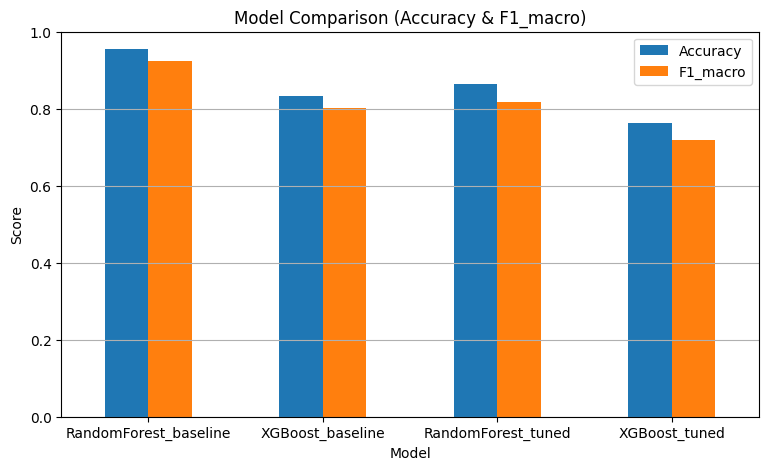

In [18]:
rows = []
rows.append({"Model": "RandomForest_baseline", "Accuracy": acc_rf, "F1_macro": f1_rf})
if acc_xgb is not None:
    rows.append({"Model": "XGBoost_baseline", "Accuracy": acc_xgb, "F1_macro": f1_xgb})
rows.append({"Model": "RandomForest_tuned", "Accuracy": acc_rf_tuned, "F1_macro": f1_rf_tuned})
if best_xgb is not None:
    rows.append({"Model": "XGBoost_tuned", "Accuracy": acc_xgb_tuned, "F1_macro": f1_xgb_tuned})

compare_df = pd.DataFrame(rows).set_index("Model")
print("\n📋 Final comparison:")
display(compare_df)

# Plot comparison
ax = compare_df.plot.bar(rot=0, figsize=(9,5), ylim=(0,1))
plt.title("Model Comparison (Accuracy & F1_macro)")
plt.ylabel("Score")
plt.grid(axis='y')
plt.show()

In [19]:
candidates = {"rf": (best_rf, f1_rf_tuned)}
if best_xgb is not None:
    candidates["xgb"] = (best_xgb, f1_xgb_tuned)

best_overall = max(candidates.items(), key=lambda x: x[1][1])[1][0]
joblib.dump(best_overall, "best_cover_model.joblib")
print("\n✅ Best model saved to best_cover_model.joblib")


✅ Best model saved to best_cover_model.joblib


In [20]:
print("\n📝 Notes:")
print("- To speed experiments: reduce n_iter in RandomizedSearchCV, or reduce n_estimators during prototyping.")
print("- For very large datasets consider using 'hist' tree_method in XGBoost and using GPU if available.")
print("- You can optionally run BayesSearchCV (skopt) for more sample-efficient hyperparameter tuning if installed.")


📝 Notes:
- To speed experiments: reduce n_iter in RandomizedSearchCV, or reduce n_estimators during prototyping.
- For very large datasets consider using 'hist' tree_method in XGBoost and using GPU if available.
- You can optionally run BayesSearchCV (skopt) for more sample-efficient hyperparameter tuning if installed.
